In [ ]:
! pip install transformers==4.34.0

In [27]:
import requests
from PIL import Image
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
model_id = "bczhou/tiny-llava-v1-hf"
prompt = "USER: <image>\nWhat are these cats doing?\nASSISTANT:"
image_file = "http://images.cocodataset.org/val2017/000000039769.jpg"
model = LlavaForConditionalGeneration.from_pretrained(
model_id,
torch_dtype=torch.float16,
low_cpu_mem_usage=True,
).to(0)
processor = AutoProcessor.from_pretrained(model_id)
raw_image = Image.open(requests.get(image_file, stream=True).raw)
inputs = processor(prompt, raw_image, return_tensors='pt').to(0, torch.float16)
output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


ER:  
What are these cats doing?
ASSISTANT: These cats are laying down on a pink couch, possibly sleeping or relaxing.


In [141]:
dummy_input = (
    inputs['input_ids'],
    inputs['pixel_values'],

    inputs['attention_mask'],
    
)

In [142]:
inputs['pixel_values'].dtype

torch.float16

In [151]:

# Define the dynamic axes for variable length inputs (if any)
dynamic_axes = {
    'input_ids': {0: 'batch_size', 1: 'sequence'},
    'pixel_values': {0: 'batch_size'},
    'attention_mask': {0: 'batch_size', 1: 'sequence'},

}

# Set the model to inference mode
model.eval()

# Export the model
torch.onnx.export(
    model, 
    dummy_input, 
    "your_model.onnx",
    export_params=True,  # Store the trained parameter weights inside the model file
    opset_version=17,  # The ONNX version to export the model to, choose based on your needs
    do_constant_folding=True,  # Whether to execute constant folding for optimization
    input_names=['input_ids', 'attention_mask', 'pixel_values'],  # Names of the input layers
    output_names=['output'],  # Names of the output layers
    dynamic_axes=dynamic_axes,  # Dynamic axes for variable length inputs
)

print("Model has been converted to ONNX format.")


In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-o

UnsupportedOperatorError: Exporting the operator 'aten::__iand_' to ONNX opset version 17 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.

In [130]:
inputs

{'input_ids': tensor([[    1,  3148,  1001, 29901, 29871, 32000, 29871,    13,  5618,   526,
          1438,   274,  1446,  2599, 29973,    13, 22933,  9047, 13566, 29901]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0'), 'pixel_values': tensor([[[[ 0.5435,  0.6455,  0.5581,  ...,  0.0909,  0.0033, -0.0696],
          [ 0.5435,  0.6167,  0.5435,  ...,  0.1201,  0.0179,  0.0617],
          [ 0.5581,  0.5581,  0.6602,  ...,  0.0909,  0.0764,  0.0617],
          ...,
          [ 1.8281,  1.8867,  1.8281,  ...,  1.4053,  1.4482,  1.5654],
          [ 1.8574,  1.9014,  1.8721,  ...,  1.4775,  1.4053,  1.4922],
          [ 1.8721,  1.9014,  1.9014,  ...,  1.4053,  1.2148,  1.4775]],

         [[-1.3623, -1.2715, -1.3770,  ..., -1.4219, -1.4824, -1.5117],
          [-1.3320, -1.2422, -1.3467,  ..., -1.4219, -1.4824, -1.4219],
          [-1.2422, -1.2871, -1.1973,  ..., -1.4668, -1.4668, -1.4824],
      

In [21]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

In [22]:
inputs['attention_mask'].shape

torch.Size([1, 20])

In [23]:
inputs['input_ids'].shape

torch.Size([1, 20])

In [35]:
inputs['input_ids']

tensor([[    1,  3148,  1001, 29901, 29871, 32000, 29871,    13,  5618,   526,
          1438,   274,  1446,  2599, 29973,    13, 22933,  9047, 13566, 29901]],
       device='cuda:0')

In [36]:
inputs['pixel_values'].shape

torch.Size([1, 3, 336, 336])

In [90]:
# Assuming a variable sequence length 'seq_len' and a fixed input size for 'pixel_values'
seq_len = 20  # This can be any representative size

dummy_input_ids = torch.randint(0, 2000, (1, seq_len))
dummy_attention_mask = torch.ones((1, seq_len), dtype=torch.long)
dummy_pixel_values = torch.randn(1, 3, 336, 336,  dtype=torch.float16)  # Assuming the size for 'pixel_values' is fixed


# Define your device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move your model to the device
model.to(device)

# Also, make sure that all input tensors are on the same device
dummy_input_ids = dummy_input_ids.to(device)
dummy_attention_mask = dummy_attention_mask.to(device)
dummy_pixel_values = dummy_pixel_values.to(device)



In [91]:
dummy_input_ids.shape

torch.Size([1, 20])

In [92]:
dummy_attention_mask.shape

torch.Size([1, 20])

In [94]:
dummy_pixel_values.dtype

torch.float16

In [95]:
i = {'input_ids': dummy_input_ids, 'attention_mask': dummy_attention_mask, 'pixel_values': dummy_pixel_values}

In [96]:
i

{'input_ids': tensor([[  89, 1578,  438,    1,   49, 1640,   81, 1245,  237, 1209, 1239,    8,
          1730,  576, 1354, 1433,  814,  392,   35, 1537]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
        device='cuda:0'),
 'pixel_values': tensor([[[[ 1.0723,  1.2480, -0.9717,  ...,  1.8594, -2.8340,  0.2688],
           [ 0.0906,  0.4333,  1.5225,  ..., -0.6978,  0.4102, -0.2756],
           [-1.5361,  2.3242, -1.1768,  ..., -0.4041, -0.7080,  0.4790],
           ...,
           [-0.9399,  0.2358, -0.1914,  ...,  0.9487,  0.3501,  0.6538],
           [-0.1464,  0.6235,  0.4058,  ..., -1.4863, -0.2849,  0.1616],
           [-0.1531, -0.9717, -1.7373,  ..., -0.1073,  1.0420,  0.1609]],
 
          [[-1.9727,  1.1289, -1.1230,  ...,  0.3345, -1.2910,  0.2333],
           [ 1.6064, -0.7261, -0.6431,  ...,  0.7642,  0.1149, -0.8862],
           [-1.4766, -0.8667,  0.2739,  ...,  0.9639,  0.6875,  1.4961],
           ...,
   

In [97]:
inputs

{'input_ids': tensor([[    1,  3148,  1001, 29901, 29871, 32000, 29871,    13,  5618,   526,
          1438,   274,  1446,  2599, 29973,    13, 22933,  9047, 13566, 29901]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0'), 'pixel_values': tensor([[[[ 0.5435,  0.6455,  0.5581,  ...,  0.0909,  0.0033, -0.0696],
          [ 0.5435,  0.6167,  0.5435,  ...,  0.1201,  0.0179,  0.0617],
          [ 0.5581,  0.5581,  0.6602,  ...,  0.0909,  0.0764,  0.0617],
          ...,
          [ 1.8281,  1.8867,  1.8281,  ...,  1.4053,  1.4482,  1.5654],
          [ 1.8574,  1.9014,  1.8721,  ...,  1.4775,  1.4053,  1.4922],
          [ 1.8721,  1.9014,  1.9014,  ...,  1.4053,  1.2148,  1.4775]],

         [[-1.3623, -1.2715, -1.3770,  ..., -1.4219, -1.4824, -1.5117],
          [-1.3320, -1.2422, -1.3467,  ..., -1.4219, -1.4824, -1.4219],
          [-1.2422, -1.2871, -1.1973,  ..., -1.4668, -1.4668, -1.4824],
      

In [111]:
inputs

{'input_ids': tensor([[    1,  3148,  1001, 29901, 29871, 32000, 29871,    13,  5618,   526,
          1438,   274,  1446,  2599, 29973,    13, 22933,  9047, 13566, 29901]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0'), 'pixel_values': tensor([[[[ 0.5435,  0.6455,  0.5581,  ...,  0.0909,  0.0033, -0.0696],
          [ 0.5435,  0.6167,  0.5435,  ...,  0.1201,  0.0179,  0.0617],
          [ 0.5581,  0.5581,  0.6602,  ...,  0.0909,  0.0764,  0.0617],
          ...,
          [ 1.8281,  1.8867,  1.8281,  ...,  1.4053,  1.4482,  1.5654],
          [ 1.8574,  1.9014,  1.8721,  ...,  1.4775,  1.4053,  1.4922],
          [ 1.8721,  1.9014,  1.9014,  ...,  1.4053,  1.2148,  1.4775]],

         [[-1.3623, -1.2715, -1.3770,  ..., -1.4219, -1.4824, -1.5117],
          [-1.3320, -1.2422, -1.3467,  ..., -1.4219, -1.4824, -1.4219],
          [-1.2422, -1.2871, -1.1973,  ..., -1.4668, -1.4668, -1.4824],
      

In [113]:
import copy

In [114]:
int2 = inputs.copy()

In [115]:
int2

{'input_ids': tensor([[    1,  3148,  1001, 29901, 29871, 32000, 29871,    13,  5618,   526,
          1438,   274,  1446,  2599, 29973,    13, 22933,  9047, 13566, 29901]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0'), 'pixel_values': tensor([[[[ 0.5435,  0.6455,  0.5581,  ...,  0.0909,  0.0033, -0.0696],
          [ 0.5435,  0.6167,  0.5435,  ...,  0.1201,  0.0179,  0.0617],
          [ 0.5581,  0.5581,  0.6602,  ...,  0.0909,  0.0764,  0.0617],
          ...,
          [ 1.8281,  1.8867,  1.8281,  ...,  1.4053,  1.4482,  1.5654],
          [ 1.8574,  1.9014,  1.8721,  ...,  1.4775,  1.4053,  1.4922],
          [ 1.8721,  1.9014,  1.9014,  ...,  1.4053,  1.2148,  1.4775]],

         [[-1.3623, -1.2715, -1.3770,  ..., -1.4219, -1.4824, -1.5117],
          [-1.3320, -1.2422, -1.3467,  ..., -1.4219, -1.4824, -1.4219],
          [-1.2422, -1.2871, -1.1973,  ..., -1.4668, -1.4668, -1.4824],
      

In [62]:
inputs['attention_mask'].shape == i['attention_mask'].shape

True

In [121]:
int2['pixel_values'] = i['pixel_values']

In [68]:
inputs['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')

In [63]:
inputs['pixel_values'].shape == i['pixel_values'].shape

True

In [122]:
output = model.generate(**int2, max_new_tokens=200, do_sample=False)
# print(processor.decode(output[0][2:], skip_special_tokens=True))

In [123]:
output

tensor([[    1,  3148,  1001, 29901, 29871, 32000, 29871,    13,  5618,   526,
          1438,   274,  1446,  2599, 29973,    13, 22933,  9047, 13566, 29901,
          4525,   274,  1446,   526,  8743,   411,  1269,   916,   297,   263,
          2927,  1319,   322, 19587,  5177, 29889,     2]], device='cuda:0')

In [127]:
# Specify the name for the ONNX file
onnx_file_name = 'model.onnx'

# Export the model
torch.onnx.export(model,
                  (int2['input_ids'], int2['attention_mask'] , int2['pixel_values'] ),  # model inputs as a tuple
                  onnx_file_name,
                  export_params=True,
                  opset_version=11,
                  do_constant_folding=True,
                  input_names=['input_ids', 'attention_mask', 'pixel_values'],
                  output_names=['output'])


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 20]

In [41]:
# Define your device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move your model to the device
model.to(device)

# Also, make sure that all input tensors are on the same device
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
pixel_values = pixel_values.to(device)


NameError: name 'input_ids' is not defined

In [25]:
prompt = "USER: <image>\nIs the man sexy?\nASSISTANT:"
inputs = processor(prompt, raw_image, return_tensors='pt').to(0, torch.float16)
output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))

ER:  
Is the man sexy?
ASSISTANT: No, the man is not sexy. He is a cat.


In [52]:
inputs

{'input_ids': tensor([[    1,  3148,  1001, 29901, 29871, 32000, 29871,    13,  5618,   526,
          1438,   274,  1446,  2599, 29973,    13, 22933,  9047, 13566, 29901]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0'), 'pixel_values': tensor([[[[ 0.5435,  0.6455,  0.5581,  ...,  0.0909,  0.0033, -0.0696],
          [ 0.5435,  0.6167,  0.5435,  ...,  0.1201,  0.0179,  0.0617],
          [ 0.5581,  0.5581,  0.6602,  ...,  0.0909,  0.0764,  0.0617],
          ...,
          [ 1.8281,  1.8867,  1.8281,  ...,  1.4053,  1.4482,  1.5654],
          [ 1.8574,  1.9014,  1.8721,  ...,  1.4775,  1.4053,  1.4922],
          [ 1.8721,  1.9014,  1.9014,  ...,  1.4053,  1.2148,  1.4775]],

         [[-1.3623, -1.2715, -1.3770,  ..., -1.4219, -1.4824, -1.5117],
          [-1.3320, -1.2422, -1.3467,  ..., -1.4219, -1.4824, -1.4219],
          [-1.2422, -1.2871, -1.1973,  ..., -1.4668, -1.4668, -1.4824],
      

In [8]:
import cv2.cv as cv 
import numpy as np  
Capture = cv.CaptureFromCAM(0)
image = cv.QueryFrame(Capture) #here you have an IplImage
imgarray = np.asarray(image[:,:]) 

ModuleNotFoundError: No module named 'cv2.cv'

In [11]:
import cv2 
  
  raw_image = Image.open(requests.get(image_file, stream=True).raw)
inputs = processor(prompt, raw_image, return_tensors='pt').to(0, torch.float16)
output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))
# define a video capture object 
vid = cv2.VideoCapture(1) 

      
# Capture the video frame 
# by frame 
ret, frame = vid.read() 

# Display the resulting frame 
cv2.imshow('frame', frame) 
    
# the 'q' button is set as the 
    # quitting button you may use any 
    # desired button of your choice 
    # if cv2.waitKey(1) & 0xFF == ord('q'): 
    #     break
  
# After the loop release the cap object 
vid.release() 
# Destroy all the windows 
cv2.destroyAllWindows() 

[ WARN:0@70.386] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video1): can't open camera by index
[ERROR:0@70.386] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range


error: OpenCV(4.8.1) /io/opencv/modules/highgui/src/window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'


In [62]:
import cv2 
  
  
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

True

In [44]:
# by frame 
ret, frame = cap.read() 

# # Display the resulting frame 
# cv2.imshow('frame', frame) 

In [61]:
# After the loop release the cap object 
cap.release() 
# Destroy all the windows 
cv2.destroyAllWindows() 

In [22]:
frame.shape

(480, 640, 3)

ER:  
Why do you think there is a computer here?
ASSISTANT: The presence of a computer in the image suggests that the man is likely working or studying from home. He is wearing a yellow sweatshirt and appears to be focused on his computer screen. The computer could be used for various tasks such as browsing the internet, working on a project, or engaging in online classes. The man's attire and the presence of the computer indicate that he is engaged in a professional or educational activity that requires the use of a computer.


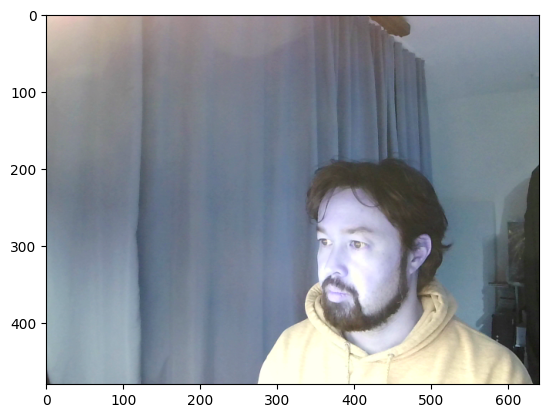

In [80]:
ret, frame1 = cap.read()
ret, frame2 = cap.read() 
plt.imshow(frame)

prompt = "USER: <image>\nWhy do you think there is a computer here?\nASSISTANT:"
inputs = processor(prompt, frame, return_tensors='pt').to(0, torch.float16)
output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))

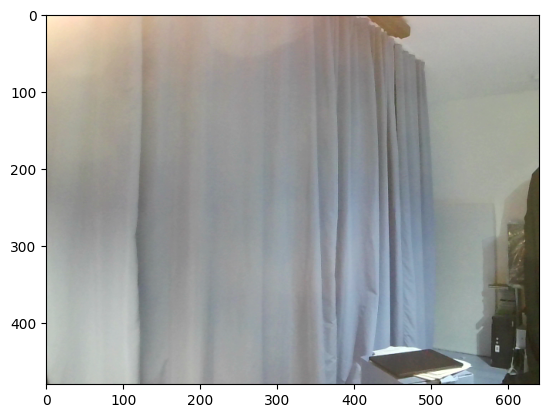

In [114]:
ret, frame = cap.read()
ret, frame = cap.read() 
plt.imshow(frame)

In [115]:
import matplotlib.pyplot as plt

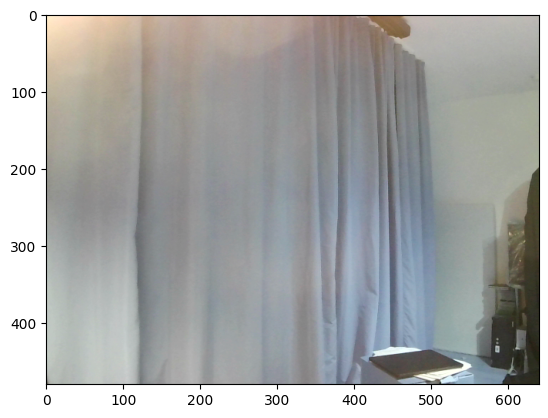

In [125]:
ret, frame1 = cap.read()
ret, frame1 = cap.read() 
plt.imshow(frame1)
# plt.imshow(frame2)

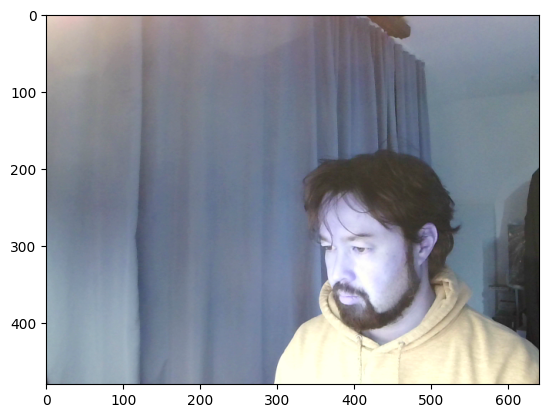

In [121]:
ret, frame2 = cap.read()
ret, frame2 = cap.read() 
plt.imshow(frame2)
# plt.imshow(frame2)

In [154]:
frame3 = np.concatenate((frame1, frame2), axis=2)

NameError: name 'np' is not defined

In [155]:
plt.imshow(frame3)

NameError: name 'plt' is not defined

In [130]:

prompt = "USER: <image>\nWhat happened between frame on the left and later frame on the right?\nASSISTANT:"
inputs = processor(prompt, frame3, return_tensors='pt').to(0, torch.float16)
output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))

ER:  
What happened between frame on the left and later frame on the right?
ASSISTANT: In the image, a person is standing in front of a curtain, and the curtain is partially open. The person is looking at a TV screen, which is located behind the curtain. The curtain is also partially open, and the TV screen is partially visible. This suggests that the person might have been watching a TV show or movie, and the curtain has been partially opened to let in some light or to create a more comfortable viewing experience.


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
torch.manual_seed(0)

path = 'openbmb/MiniCPM-2B-dpo-bf16'
tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModelForCausalLM.from_pretrained(path, torch_dtype=torch.bfloat16, device_map='cuda', trust_remote_code=True)

responds, history = model.chat(tokenizer, "Explaing the toungetwister about woodchucks？", temperature=0.8, top_p=0.8)
print(responds)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The "Toungetwister" is not a widely recognized or established term when it comes to woodchucks, also known as groundhogs or three-toed groundhogs. Woodchucks are part of the Sciuridae family, which also includes squirrels, chipmunks, and other ground-dwelling mammals. They are native to North America and are known for their burrowing habits and ability to dig through the ground.

Woodchucks are omnivorous animals, feeding on a variety of foods such as insects, fruits, seeds, and small animals like insects, spiders, and worms. They are also known to be quite social and can often be found in large groups, or "herds," in the early morning and evening.

If you are referring to a different term or concept related to woodchucks, please provide more information so I can provide a more accurate and relevant explanation.


In [4]:
responds, history = model.chat(tokenizer, "How is icecreame made？", temperature=0.8, top_p=0.8)
print(responds)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Ice cream is a delicious frozen dessert made from a mixture of dairy products, typically milk, cream, and sometimes a sweetener like sugar. The process of making ice cream involves the following steps:

1. Base ingredients: The primary ingredients for ice cream are milk, cream, and sugar. Other ingredients may be added, such as flavorings, colorings, or other sweeteners.
2. Mixing: The base ingredients are mixed together in a large bowl or container. The mixture is typically whisked or blended until the ingredients are well combined.
3. Churning: In a machine called an ice cream maker, the mixture is churned at a high speed. This process emulsifies the ingredients and creates a smooth, creamy texture.
4. Freezing: The churned ice cream mixture is then transferred to an ice cream freezer or ice cream machine. The mixture is frozen at a low temperature, typically between -18°C and -20°C (0°F to -4°F).
5. Thawing and serving: Once the ice cream has frozen, it is removed from the machine a

In [6]:

themeExample = "Imagine what alien communication might be like and create a hypothetical scenario for initial contact."

entryExample = """Title: "Whispers from the Cosmos: A Symphony of Stars"
In the vast expanse of the cosmos, where stars are born and die in a celestial ballet, a new player entered the stage. A planet, hitherto unknown to us, orbited a star in the constellation of Cygnus. This planet, christened as Kepler-438b, was a veritable gem, with conditions conducive to life.
One fateful day, as the sun set on the eastern horizon of our planet, an anomaly occurred. The radio telescopes at SETI (Search for Extraterrestrial Intelligence) Institute picked up a signal. It was unlike anything they had ever encountered before. The signal, pulsating at regular intervals, was not random but seemed to carry a pattern.
The scientists were baffled. They worked tirelessly, decoding the signal, trying to make sense of it. Days turned into weeks, and weeks into months. The signal was not a noise; it was a message.
The message was a series of complex mathematical equations, interwoven with intricate melodies. It was a language, unlike any human language. The team at SETI, led by Dr. Amelia Hartman, worked tirelessly to decode the message. They discovered that the message contained instructions to build a device, which they named the "Cosmic Harmonizer."
The Cosmic Harmonizer was a device that could transmit and receive signals across interstellar distances. It was a marvel of engineering, a testament to the advanced technology of the extraterrestrial beings.
Dr. Hartman and her team built the Cosmic Harmonizer, and they sent a response. They transmitted a message, a greeting to the aliens, containing information about Earth and its inhabitants. They also included a recording of Beethoven's "Moonlight Sonata," a piece of music that transcended language and culture.
The response was met with silence. But then, a few days later, they received another message. It was a reply, a musical composition, a melody that resonated with the frequencies of the "Moonlight Sonata." It was a beautiful symphony, a conversation starter between two civilizations separated by light-years.
The initial contact had been made. The aliens had communicated, not through words, but through music and mathematics. It was a beautiful, harmonious exchange, a testament to the power of communication and the universality of art.
From that day forward, humanity and the extraterrestrial beings began a dialogue, a conversation that spanned the cosmos. They shared knowledge, ideas, and cultures. They learned from each other, growing together as one interconnected civilization. And so, the universe sang a new song, a symphony of stars, a testament to the power of communication and the boundless possibilities of the cosmos."""

In [8]:
def dictToString(ratingsDict: dict) -> str:
    """Convert a dictionary of ratings to a string.

    Each rating is a line in the string, with the key, value, and letter of the rating the LLM should use.
    This is done by converting the key to a letter, starting with 'a' and incrementing by one for each rating.

    LLM's are very bad at understanding numbers, so we use a descriptive word for each rating instead, and have the LLM
    convert it to a letter.

    Args:
        ratingsDict (dict): Dictionary of ratings"""

    return "\n".join(
        [
            f"{key} = {chr(ord('a')+i)}: {value}"
            for i, (key, value) in enumerate(ratingsDict.items())
        ]
    )


In [63]:

# the ratings are on a scale of 0-10, with 0 being the worst and 10 being the best, although the this can be continued and is not limited to 10. What is important is the descriprion of the rating!
craftsmanshipDefinition = {
    "Incoherent": "Completely lacks structure, clarity, and basic understanding of writing principles.",
    "Amateurish": "Lacks basic structure and polish.",
    "Inexperienced": "Shows some understanding but is fundamentally flawed.",
    "Developing": "Basic skills present but lacking refinement.",
    "Competent": "Adequate execution with some errors.",
    "Skilled": "Good quality with minor lapses.",
    "Proficient": "Strong, consistent quality with few errors.",
    "Artistic": "Shows flair and style beyond mere technical proficiency.",
    "Masterful": "Exceptional skill and precision.",
    "Brilliant": "Outstanding craftsmanship, innovative and flawless.",
    "Transcendent": "Sets a new standard, impeccable in every aspect.",
}

creativityDefinition = {
    "Clone": "Offers no original thought or perspective; a mere copy of existing works.",
    "Unimaginative": "Completely derivative and lacking originality.",
    "Basic": "Few original ideas, mostly predictable.",
    "Simple": "Shows some originality but largely conventional.",
    "Interesting": "Regular flashes of creativity.",
    "Inventive": "Consistently creative and engaging.",
    "Inspired": "Rich in original ideas and perspectives.",
    "Innovative": "Breaks new ground, very original.",
    "Visionary": "Exceptionally creative and forward-thinking.",
    "Revolutionary": "Radically original, transforming norms.",
    "Genius": "Redefines the concept of creativity.",
}

consistencyDefinition = {
    "Disconnected": "Shows no understanding or recognition of the theme; entirely unrelated.",
    "Irrelevant": "Fails to address the theme.",
    "Off-Topic": "Barely touches on the theme.",
    "Wandering": "Occasionally relevant but often strays.",
    "Variable": "Inconsistent adherence to the theme.",
    "Steady": "Generally sticks to the theme with some lapses.",
    "Focused": "Consistently on-theme with minor deviations.",
    "Harmonious": "Well-integrated with the theme, showing depth.",
    "Unified": "Seamlessly blends all elements with the theme.",
    "Exemplary": "Outstanding representation of the theme.",
    "Definitive": "The ultimate expression of the theme.",
}

criteria = {
    "craftsmanship": "Craftsmanship - focuses on the writer's skill in structuring sentences, paragraphs, and stylistic precision.\n",
    "creativity": "Creativity - encompasses the writer's flair for innovation, the use of vivid and original imagery, and the ability to engage readers with fresh perspectives and unexpected narrative turns.\n",
    "consistency": "Consistency - indicates the writer's skill in maintaining relevance to the theme, ensuring that all parts of the writing contribute to and resonate with the central idea, without deviating or diluting the thematic focus.\n",
}


In [64]:
theme = "Write about the execution of a famous pirate. Write from the perspective of the hooded executioner."

In [65]:
entry = """In the heart of the Old World, where the sun sets in a blaze of crimson and gold, lies the bustling seaport of Port Royal. Its cobblestone streets echo with the cacophony of merchants hawking their wares, sailors singing shanties, and children laughing. But beneath this veneer of merriment, lurks an inescapable truth: this is a town built on the blood of the damned. I am its grim guardian.
I, the Hooded Reaper, have borne witness to countless lives claimed by the merciless sea and the even more merciless men who ply her waters. Today, I stand at the precipice of another tale of infamy, as the life of a notorious pirate comes to an end.
The sun had barely risen when the shackled figure was led before me. His name was Blackbeard, the terror of the Seven Seas. His legend had grown like a cancer, spreading fear and awe in equal measure. He stood tall and defiant, his eyes burning with the fire of rebellion. But as he looked upon me, he knew his time had come.
As the crowd gathered, I could feel the weight of their anticipation. They came to see justice served, to witness the spectacle of a pirate's end. I, too, had grown weary of Blackbeard's reign of terror. Yet, as I prepared to execute him, I couldn't help but feel a pang of sadness. For beneath the fear and the violence, there was a man - a man who had once been a part of this very community.
Blackbeard's hands were bound, his beard hidden beneath a thick hood. He looked every inch the pirate king, his eyes filled with a mixture of defiance and resignation. As I approached, he spoke, his voice barely above a whisper.
"Reaper," he said, "I know what you are. I've seen the likes of you before. But I've lived a good life, taken what I wanted, and given as good as I got. I've earned my place in the afterlife."
I remained silent, my face hidden behind the mask of my hood. I had heard such words before, from men and women who thought they had lived lives worth living. But the law was the law, and there was no room for mercy in its cold, unyielding grasp.
As the noose was placed around his neck, Blackbeard's demeanor changed. He closed his eyes, took a deep breath, and spoke one final words.
"Farewell, Reaper. May the sea be kind to you."
With that, he jumped from the makeshift gallows, the noose tightening around his neck. The crowd gasped in shock, but I knew what was coming. I watched as the life drained from his eyes, his body twitching and convulsing in its final moments. And then, silence.
As the sun set over Port Royal, I stood there, the Hooded Reaper, watching as the tide carried Blackbeard's lifeless body away. Another pirate's tale had come to an end, another chapter in the endless saga of the sea written in the blood of the damned. But as I turned to leave, I couldn't help but wonder: would there ever be an end to this cycle of violence and retribution? Or would the sea forever be stained with the blood of those who dared to defy the law?
And so, I continue my vigil, the Hooded Reaper, the grim guardian of Port Royal, waiting for the next tale of infamy to unfold. For the sea is a cruel mistress, and her children are a restless, violent lot. But I will be there, ready to mete out justice, no matter the cost."""

In [66]:
criteriaName = "craftsmanship"
criteriaDefinition = craftsmanshipDefinition

In [73]:
def generatePrompt(theme, entry, criteriaName, criteriaDefinition):
    prompt = "As a professional editor and connoisseur of literature, your role is pivotal in assessing the upcoming story. This narrative is a submission for a prestigious competition aimed at nurturing amateur writers, making it imperative that your evaluation is both equitable and comprehensive. Prior to assigning your score, you are encouraged to engage deeply with the content, ensuring that your critique is informed and nuanced. The central theme of the narrative will be disclosed to guide your analysis. Additionally, a structured ranking system will be made available to you, designed to streamline the evaluation process and maintain consistency across various dimensions of literary excellence. Your expert judgement is not just a contribution, but a cornerstone in the advancement and recognition of emerging literary talent. \n\n***** Given Theme *****\n" \
            + theme \
            + "\n\n***** Competition Entry *****\n" \
            + entry \
            + "\n\n**** Rating System *****\nUse the following rating system " \
            + criteria[criteriaName] \
            + "\n" \
            + dictToString(criteriaDefinition) \
            + "\n\nUpon reviewing the narrative in accordance with the provided rating systems, please concentrate your evaluation into a singular, precise judgement for the entry. Respond with only one character that aligns with your considered evaluation, ranging from the lowest to the highest tier as defined.\n" \
            + "\n***** Rating *****\n" \
            + "'"
    return prompt



In [74]:
print(generatePrompt(themeExample, entryExample, criteriaName, criteriaDefinition) + "f'\n\n" + generatePrompt(theme, entry, criteriaName, criteriaDefinition))

As a professional editor and connoisseur of literature, your role is pivotal in assessing the upcoming story. This narrative is a submission for a prestigious competition aimed at nurturing amateur writers, making it imperative that your evaluation is both equitable and comprehensive. Prior to assigning your score, you are encouraged to engage deeply with the content, ensuring that your critique is informed and nuanced. The central theme of the narrative will be disclosed to guide your analysis. Additionally, a structured ranking system will be made available to you, designed to streamline the evaluation process and maintain consistency across various dimensions of literary excellence. Your expert judgement is not just a contribution, but a cornerstone in the advancement and recognition of emerging literary talent. 

***** Given Theme *****
Imagine what alien communication might be like and create a hypothetical scenario for initial contact.

***** Competition Entry *****
Title: "Whisp

In [75]:

def generateAllPrompt(theme, entry):
    return {
        "craftsmanship": generatePrompt(themeExample, entryExample, "craftsmanship", craftsmanshipDefinition) + "f'\n\n" + generatePrompt(theme, entry, "craftsmanship", craftsmanshipDefinition),

        "creativity": generatePrompt(themeExample, entryExample, "creativity", creativityDefinition) + "f'\n\n" + generatePrompt(theme, entry, "creativity", creativityDefinition),

        "consistency": generatePrompt(themeExample, entryExample, "consistency", consistencyDefinition) + "f'\n\n" + generatePrompt(theme, entry, "consistency", consistencyDefinition),
    }



In [76]:
prompts = generateAllPrompt(theme, entry)

In [77]:
print(prompts["creativity"])

As a professional editor and connoisseur of literature, your role is pivotal in assessing the upcoming story. This narrative is a submission for a prestigious competition aimed at nurturing amateur writers, making it imperative that your evaluation is both equitable and comprehensive. Prior to assigning your score, you are encouraged to engage deeply with the content, ensuring that your critique is informed and nuanced. The central theme of the narrative will be disclosed to guide your analysis. Additionally, a structured ranking system will be made available to you, designed to streamline the evaluation process and maintain consistency across various dimensions of literary excellence. Your expert judgement is not just a contribution, but a cornerstone in the advancement and recognition of emerging literary talent. 

***** Given Theme *****
Imagine what alien communication might be like and create a hypothetical scenario for initial contact.

***** Competition Entry *****
Title: "Whisp